In [18]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import json

import quandl as quandl
import os

#KEY = '...'
#!mkdir ./.keys
#with open('./.keys/quandl-api-key.json','w') as f:
#    json.dump({'key': KEY}, f)

KEYFILE = './.keys/quandl-api-key.json'
if os.path.exists(KEYFILE):
    with open('./.keys/quandl-api-key.json','r') as f:
        quandl_token = json.load(f)['key']
        
    import functools
    _quandl_get = functools.partial(quandl.get, authtoken=quandl_token)
else:
    _quandl_get = quandl.get
    
print(pd.__version__, np.__version__)

('0.12.0', '1.7.1')


In [19]:
# http://www.quandl.com/FRED-Federal-Reserve-Economic-Data/USARGDPR-Real-GDP-in-the-United-States
# http://www.quandl.com/FRED-Federal-Reserve-Economic-Data/GDP-Gross-Domestic-Product-1-Decimal
# http://www.quandl.com/FRED-Federal-Reserve-Economic-Data/FYGFD-Gross-Federal-Debt
# http://www.quandl.com/FRED-Federal-Reserve-Economic-Data/USAPOPL-Population-in-the-United-States
# http://www.quandl.com/FRED-Federal-Reserve-Economic-Data/CPIAUCSL-Consumer-Price-Index-for-All-Urban-Consumers-All-Items-USA-Inflation
import collections
_data = collections.OrderedDict()
for _key in ['FRED/USARGDPR', 'FRED/GDP', 'FRED/FYGFD', 'FRED/USAPOPL', 'FRED/CPIAUCSL']:
    _data[_key.replace('/','_')] = _quandl_get(_key)


No authentication tokens found: usage will be limited.
See www.quandl.com/api for more information.
Returning Dataframe for  FRED/USARGDPR
No authentication tokens found: usage will be limited.
See www.quandl.com/api for more information.
Returning Dataframe for  FRED/GDP
No authentication tokens found: usage will be limited.
See www.quandl.com/api for more information.
Returning Dataframe for  FRED/FYGFD
No authentication tokens found: usage will be limited.
See www.quandl.com/api for more information.
Returning Dataframe for  FRED/USAPOPL
No authentication tokens found: usage will be limited.
See www.quandl.com/api for more information.
Returning Dataframe for  FRED/CPIAUCSL


In [20]:
mpl.rcParams['figure.figsize'] = (20,4)

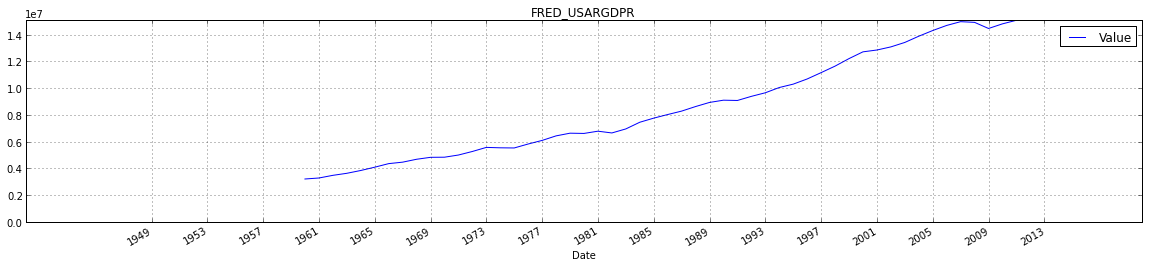

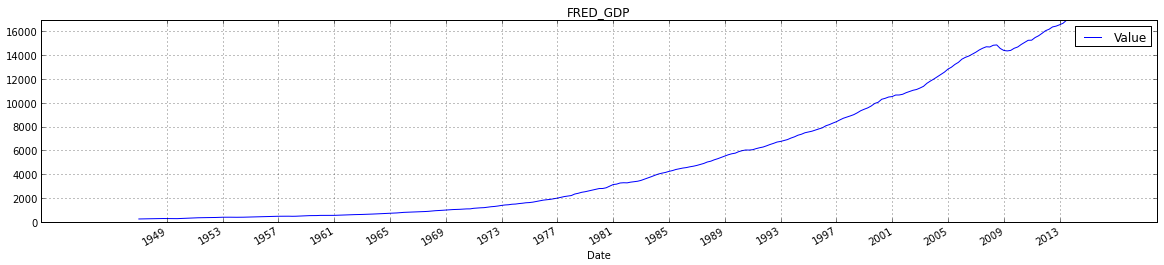

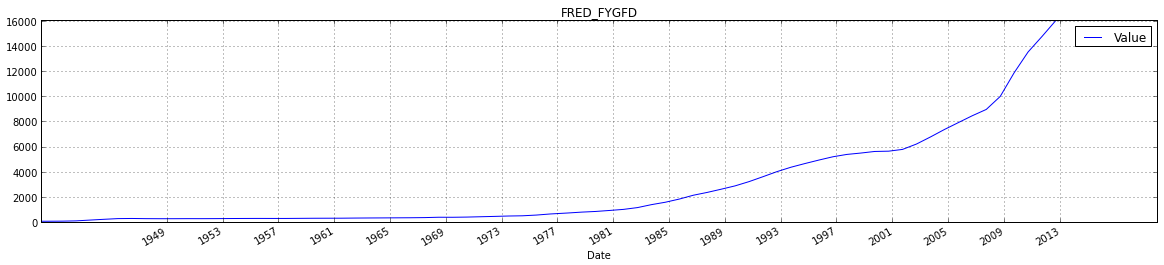

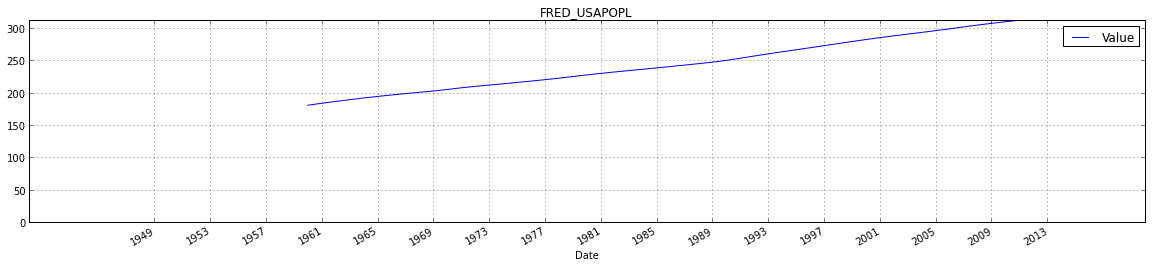

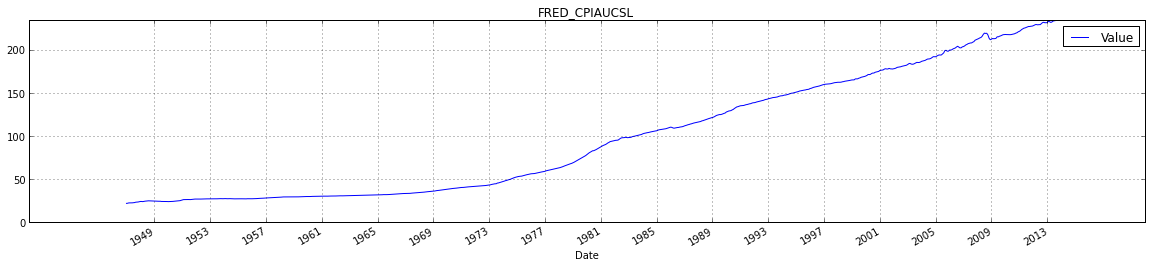

In [21]:

for k,v in _data.iteritems():
    v.plot(
        title=k,
        xlim=('1940','2020'),
        ylim=(0, v.max()),
        xticks=[str(x) for x in range(1949,2017,4)],
        x_compat=True)
#usargdpr.plot(), usagdp.plot(), fygfd.plot(), popl.plot()
#usargdpr.

In [22]:
_data['FRED_USARGDPR'].head(), _data['FRED_FYGFD'].head()

(              Value
Date               
1960-01-01  3206354
1961-01-01  3281057
1962-01-01  3479888
1963-01-01  3632016
1964-01-01  3842183,
             Value
Date             
1939-06-30   48.2
1940-06-30   50.7
1941-06-30   57.5
1942-06-30   79.2
1943-06-30  142.6)

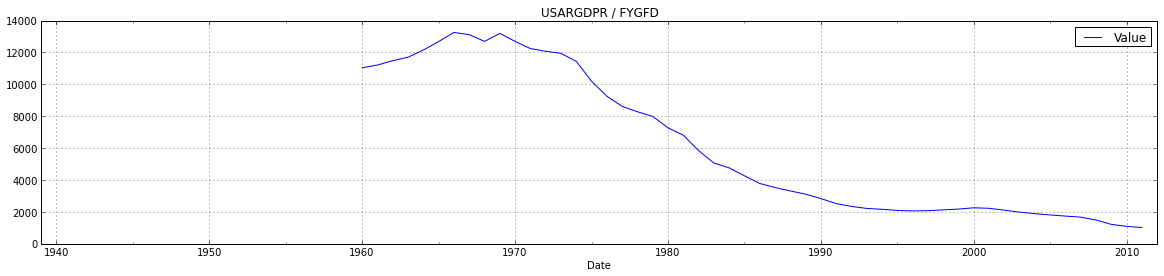

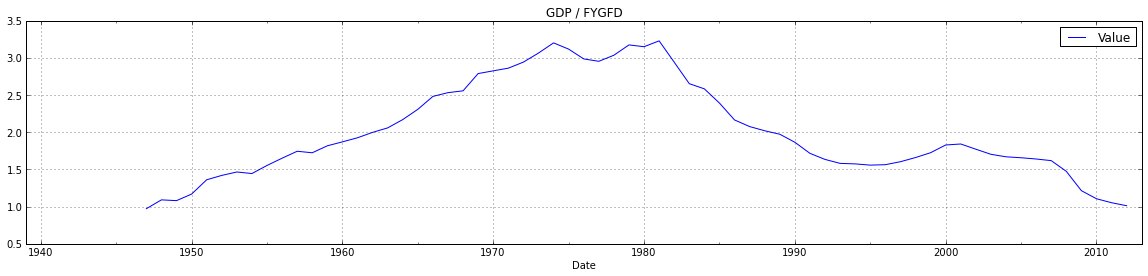

In [23]:
((_data['FRED_USARGDPR'].resample('A', how='mean'))
 / _data['FRED_FYGFD'].resample('A', how='mean')).plot(title='USARGDPR / FYGFD')
((_data['FRED_GDP'].resample('A', how='mean'))
 / _data['FRED_FYGFD'].resample('A', how='mean')).plot(title='GDP / FYGFD')

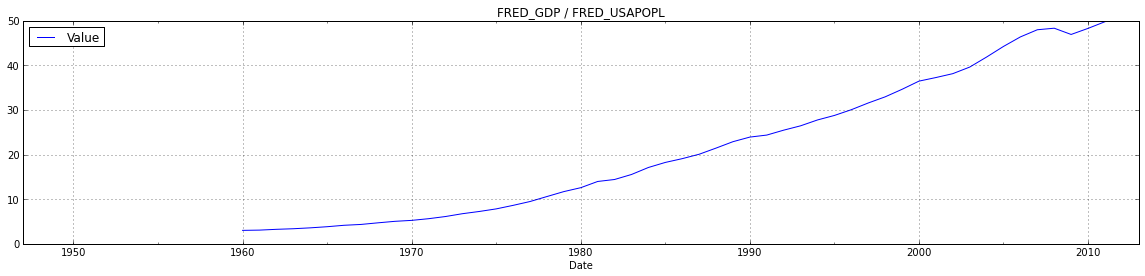

In [24]:
((_data['FRED_GDP'].resample('A', how='mean'))
 / _data['FRED_USAPOPL'].resample('A', how='mean')).plot(title='FRED_GDP / FRED_USAPOPL')

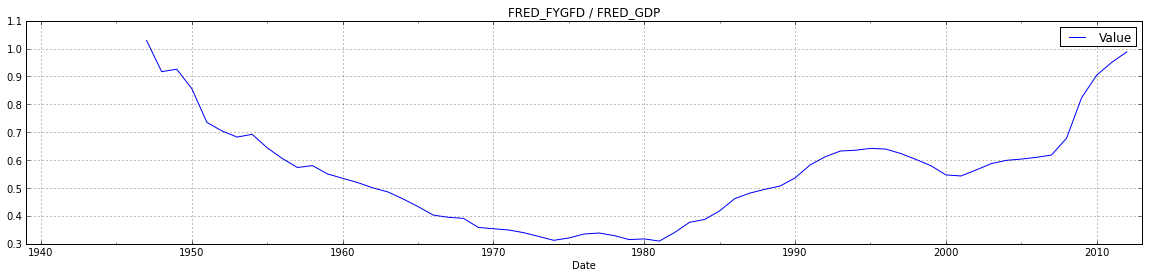

In [25]:
((_data['FRED_FYGFD'].resample('A', how='mean'))
 / _data['FRED_GDP'].resample('A', how='mean')).plot(title='FRED_FYGFD / FRED_GDP')

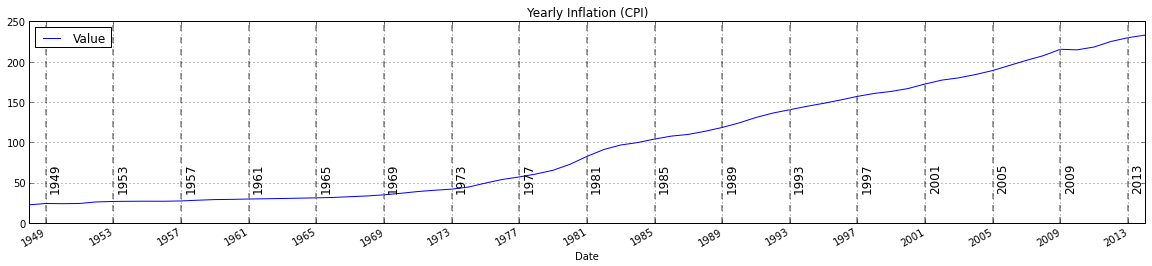

In [26]:
plot = _data['FRED_CPIAUCSL'].resample('A', how='mean').plot(
    xticks=[str(x) for x in range(1949,2017,4)],
    x_compat=True,
    title="Yearly Inflation (CPI)"
    )
plot.legend(loc='upper left')


def add_line(plot, _year, text=None):
    _max = plot.yaxis.get_view_interval()[-1]
    plot.plot((_year,_year), (0, _max),
            color='gray', linewidth=1.5, linestyle="--")
    plot.annotate(
                text if text is not None else _year,
                xy=(_year, 0),
                xycoords='data',
                xytext=(+10, +30),
                textcoords='offset points',
                fontsize=12,
                #arrowprops=dict(arrowstyle="->"), #, connectionstyle=""), #arc3,rad=.2"),
                rotation='vertical',
                verticalalignment='bottom',
                horizontalalignment='center')

for year in range(1949, 2017, 4):
    add_line(plot, str(year))

display(plot)


In [27]:

def get_presidents_df(data_file='./data/us_presidents.csv'):
    #!wget 'https://commondatastorage.googleapis.com/ckannet-storage/2012-05-08T122246/USPresident-Wikipedia-URLs-Thmbs-HS.csv' -O ./data/us_presidents.csv
    df = presidents = pd.read_csv(data_file)
    
    df = presidents[['President ','Took office ','Left office ']]
    df['Took office '] = pd.to_datetime(presidents['Took office '])
    df['Left office '] = pd.to_datetime(presidents['Left office '], coerce=True)
    #display(df)
    df = df.set_index('Took office ', drop=False, verify_integrity=True)
    df['term'] = df['Left office '] - df['Took office ']
    
    col = df['term']
    val = col[0]
    df['term'] = (
        col.apply(
            lambda x: x.astype('timedelta64[D]'),
            convert_dtype=False))
    col = df['term']
    val = col[0]
    val.item().days
    df['terms'] = df['term'].apply(
        lambda x: (x.item().days if x.item() else 0)
        / float(365.25*4))
    return df

#df['terms'] = (df['term'] / np.timedelta64(1, 'D')) / float(365.25*4) # pandas 0.13

df = get_presidents_df()
display(df.head())

def presidents_by_year(df=None):
    if df is None:
        df = get_presidents_df()
    for year,name in df.ix[:,['President ']].to_records():
        print(year.year, name)

def add_presidents(plot, presidents=None, yearmin=0):
    if presidents is None:
        presidents = get_presidents_df()

    for year,name in presidents.ix[str(yearmin):,['President ']].to_records():
        #print year.year, name
        add_line(plot, year, name)

def poli_plot(df, **kwargs):
    yearmin = df.index.min().year
    yearmax = 2017
    
    plot = df.plot(
        xticks=[str(x) for x in range(yearmax, yearmin,-4)],
        x_compat=True,
        **kwargs)
    plot.legend(loc='upper left')
    
    add_presidents(plot, yearmin=yearmin)


,President,Took office,Left office,term,terms
Took office,,,,,
1789-04-30,George Washington,1789-04-30 00:00:00,1797-04-03 00:00:00,2895 days,1.981520
1797-04-03,John Adams,1797-04-03 00:00:00,1801-04-03 00:00:00,1460 days,0.999316
1801-04-03,Thomas Jefferson,1801-04-03 00:00:00,1809-04-03 00:00:00,2922 days,2.000000
1809-04-03,James Madison,1809-04-03 00:00:00,1817-04-03 00:00:00,2922 days,2.000000
1817-04-03,James Monroe,1817-04-03 00:00:00,1825-04-03 00:00:00,2922 days,2.000000


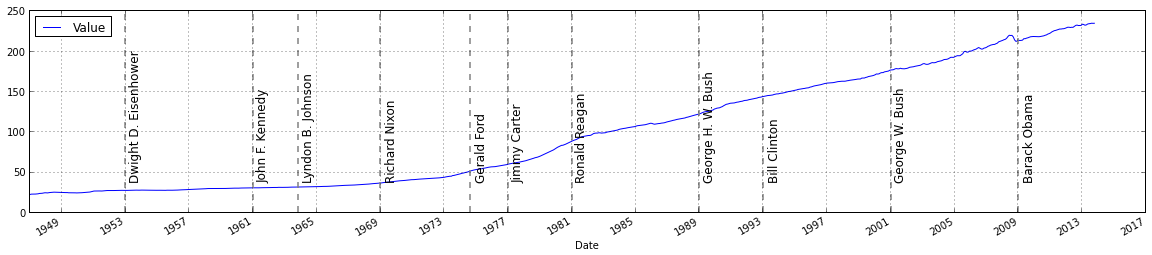

In [28]:

df = _data['FRED_CPIAUCSL']
poli_plot(df)

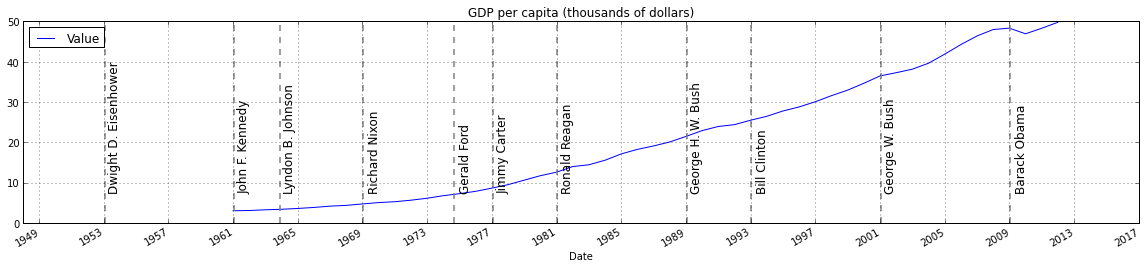

In [29]:
df = ((_data['FRED_GDP'].resample('A', how='mean')) / _data['FRED_USAPOPL'].resample('A', how='mean'))
poli_plot(df, title="GDP per capita (thousands of dollars)")

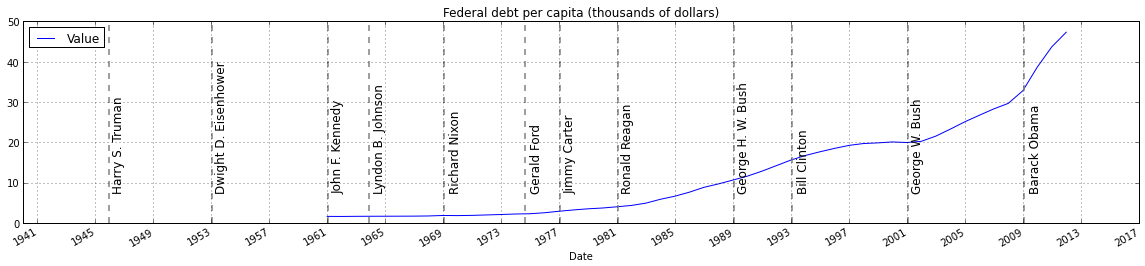

In [30]:
df = ((_data['FRED_FYGFD'].resample('A', how='mean')) / _data['FRED_USAPOPL'].resample('A', how='mean'))
poli_plot(df, title="Federal debt per capita (thousands of dollars)")

No authentication tokens found: usage will be limited.
See www.quandl.com/api for more information.
Returning Dataframe for  FRED/GFDEBTN
No authentication tokens found: usage will be limited.
See www.quandl.com/api for more information.
Returning Dataframe for  FRED/CP
No authentication tokens found: usage will be limited.
See www.quandl.com/api for more information.
Returning Dataframe for  FRED/GDP
No authentication tokens found: usage will be limited.
See www.quandl.com/api for more information.
Returning Dataframe for  FRED/CPIAUCSL


,fred_cp,fred_gdp,fred_gfd,fred_cpi
fred_cp,1.000000,0.943528,0.962850,0.885048
fred_gdp,0.943528,1.000000,0.956159,0.983052
fred_gfd,0.962850,0.956159,1.000000,0.914016
fred_cpi,0.885048,0.983052,0.914016,1.000000


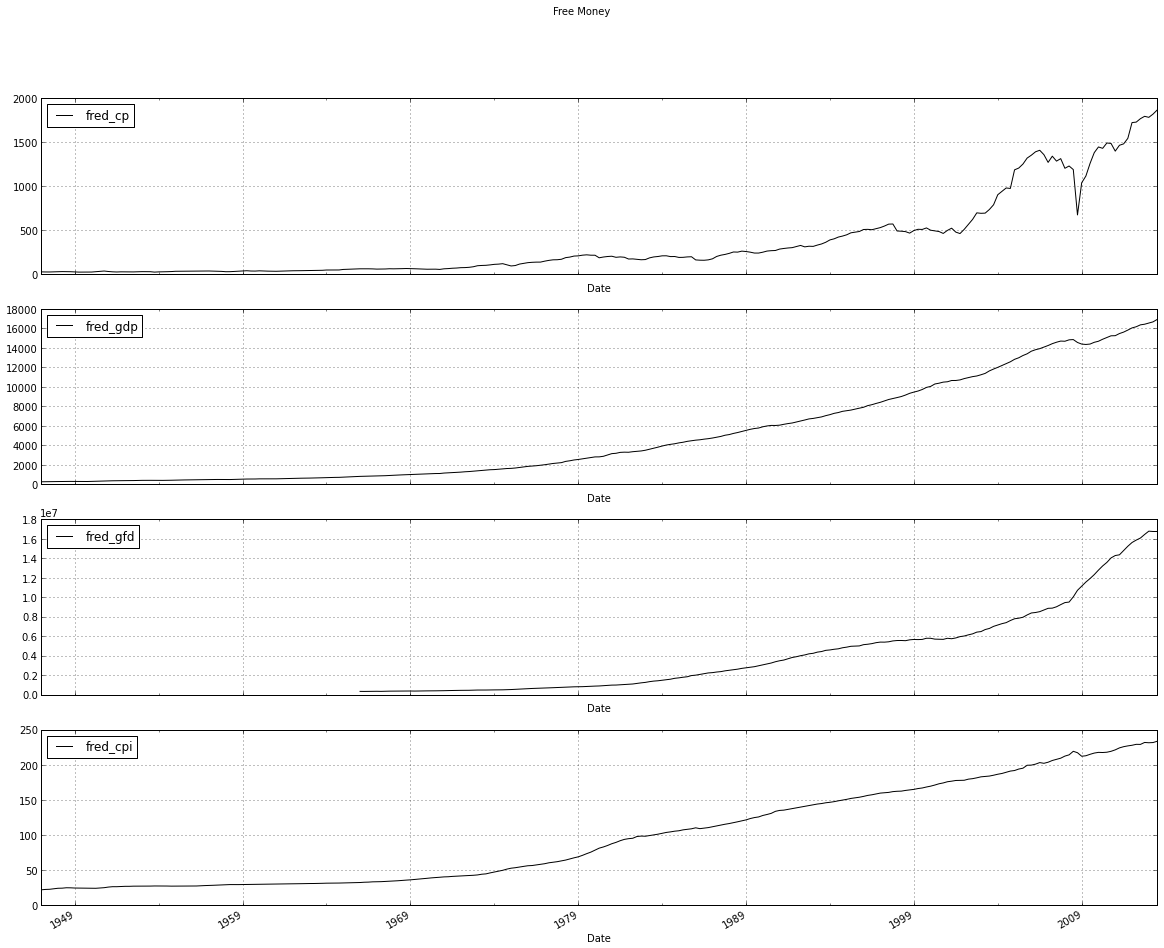

In [33]:
## Download datasets

# http://www.quandl.com/FRED-Federal-Reserve-Economic-Data/GFDEBTN-Federal-Government-Debt-Total-Public-Debt
national_debt = quandl.get('FRED/GFDEBTN')
fred_gfdebtn = national_debt

# http://www.quandl.com/FRED-Federal-Reserve-Economic-Data/CP-Corporate-Profits-After-Tax
corporate_profits_after_tax = quandl.get('FRED/CP')
fred_cp = corporate_profits_after_tax

# http://www.quandl.com/FRED-Federal-Reserve-Economic-Data/GDP-Gross-Domestic-Product-1-Decimal
gdp = quandl.get('FRED/GDP')
fred_gdp = gdp

# http://www.quandl.com/FRED-Federal-Reserve-Economic-Data/CPIAUCSL-Consumer-Price-Index-for-All-Urban-Consumers-All-Items-USA-Inflation
inflation = quandl.get('FRED/CPIAUCSL')
fred_cpi = inflation

## To one DataFrame (with a common date index)
fred_cp.rename(columns={'Value': 'fred_cp'}, inplace=True)
fred_gfdebtn.rename(columns={'Value': 'fred_gfdebtn'}, inplace=True)
fred_gdp.rename(columns={'Value': 'fred_gdp'}, inplace=True)
fred_cpi.rename(columns={'Value': 'fred_cpi'}, inplace=True)

fred_cp['fred_gdp'] = fred_gdp['fred_gdp']
fred_cp['fred_gfd'] = fred_gfdebtn['fred_gfdebtn']
fred_cp['fred_cpi'] = fred_cpi['fred_cpi']

## Draw plots
fred_cp.plot(subplots=True, sharex=True, title='Free Money', figsize=(20,4*len(fred_cp.columns)))

## Calculate pairwise correlation
# http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.corr.html
fred_cp.corr()

In [34]:
print(fred_cp.corr())

           fred_cp  fred_gdp  fred_gfd  fred_cpi
fred_cp   1.000000  0.943528  0.962850  0.885048
fred_gdp  0.943528  1.000000  0.956159  0.983052
fred_gfd  0.962850  0.956159  1.000000  0.914016
fred_cpi  0.885048  0.983052  0.914016  1.000000
